# Libro para predecir las 4 semanas futuras del valor del dolar

Aquí se adelanta un poco del trabajo a realziar sobre los datos, 
creando las funciones y llamando al modelo que se va a utilizar.

In [1]:
#%pip install tensorflow


In [2]:
#Librerias en uso

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

fecha inicial:  1990-01-07T00:00:00.000000000 , fecha final:  2023-08-06T00:00:00.000000000


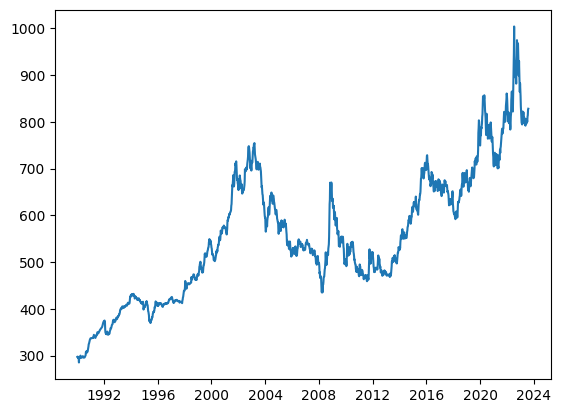

In [27]:
# importacion de los datos e ingenieria para obtener más información del valor semanal
df_neto = pd.read_csv('./valor_clp-usd_3007.csv')
df_neto['Serie'] = pd.to_datetime(df_neto['Serie'])

df_neto = df_neto.set_index('Serie')
df= df_neto.resample('W').mean()
df['min'] = df_neto.resample('W').min()
df['max'] = df_neto.resample('W').max()
df['std'] = df_neto.resample('W').std() # valor de la desviación estandar 
#df['tend']= df['max'] - df['min']
df['tend']= (df['max'] + df['min'] - 2*df['Dólar observado']) # Valor para determinar la tendencia 
df.pop('max')
df.pop('min')
x = df.index.values
y, y2, y3 = df['Dólar observado'], df['std'], df['tend']

fig, ax = plt.subplots()

ax.plot(x,y, label = 'Dolar') 


print('fecha inicial: ',min(x),', fecha final: ',max(x))

## Primera parte: división de los datos en entrenamiento, validación y prueba

Se define una función para realizar la división de los datos, al ser una serie temporal se separan por "tramos" y no aleatoriamente como con otros modelos de IA

In [4]:
def tvt_split(serie, tr_size=0.7, vl_size=0.15, ts_size=0.15 ): ## VALORES DE DIVISIÓN PREDEFINIDOS EN LA FUNCIÓN
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[Nval:Ntrain+Nval]
    val = serie[Ntrain+Nval:]
    test = serie[:Nval]

    return train, val, test

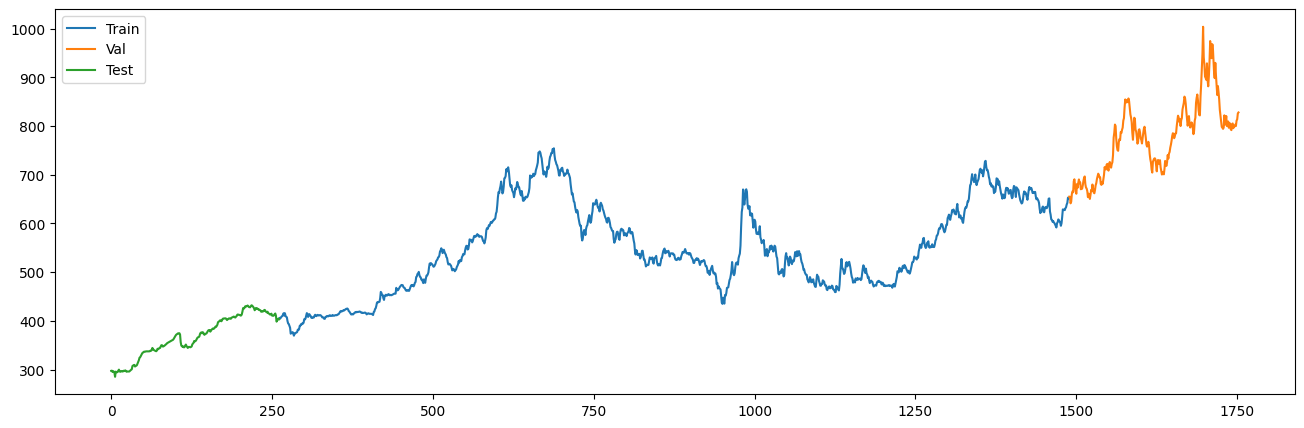

In [5]:
# Dividir los datos con la función
df2 = df.reset_index()
df2.pop('Serie')


tr, vl, ts = tvt_split(df2)


# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr['Dólar observado'], label='Train')
ax.plot(vl['Dólar observado'], label='Val')
ax.plot(ts['Dólar observado'], label='Test')
plt.legend()#;

## Segunda parte: Crear los datasets dependientes e independientes para el entremamiento del modelo

Se define una función para la división de los conjuntos en X e Y. Además de ajustarse al formato que se requiere para el entrenamiento del modelo

In [6]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,0].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [7]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 156    ## Posteriormente afinaremos este hiperparámetro ---- Aquí deben ir las semanas que se usan para buscar patrones donde se predice el comportamiento del USD/CLP
OUTPUT_LENGTH = 4    # Modelo multi-step: ***EL ÚNICO CAMBIO QUE DEBEMOS HACER***

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1067, 156, 3), y_tr: (1067, 4, 1)
Set de validación - x_vl: (104, 156, 3), y_vl: (104, 4, 1)
Set de prueba - x_ts: (102, 156, 3), y_ts: (102, 4, 1)


## Tercera parte: Escalamiento de los datos

Al aplicar una escala en los datos beneficia el entrenamiento del modelo, además hace mas facil la comprensión de la relación entre las variables usadas en el modelo.

In [8]:
def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''
    
    NFEATS = data_input['x_tr'].shape[2]
    

    # Generar listado con "scalers" 
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets
    
    X = np.concatenate((x_tr,x_vl,x_ts),axis=0)
    
    # Escalamiento Xs
    for i in range(NFEATS):

        scalers[i].fit(X[:,:,i])
        x_tr_s[:,:,i] = scalers[i].transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    Y = np.concatenate((y_tr,y_vl,y_ts),axis=0)
    scalers[-1].fit(Y[:,:,0])
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[-1]

In [9]:
# Escalamiento del dataset con la función anterior


# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}\n\
    Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}\n\
    \nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}\n\
    Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}\n\
    \nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}\n\
    Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}\n\
    \nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}\n\
    Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: -7.557999999999993/-12.690000000000055/-10.330000000000155
    Min x_tr/x_vl/x_ts con escalamiento: -1.0/-1.0/-1.0000000000000002
    
Min y_tr/y_vl/y_ts sin escalamiento: 434.9725/746.8225/381.72333333333336
    Min y_tr/y_vl/y_ts con escalamiento: -0.834517093562215/0.17394727139433463/-1.0000000000000002
    
Max x_tr/x_vl/x_ts sin escalamiento: 754.29/1003.726/431.98199999999997
    Max x_tr/x_vl/x_ts con escalamiento: 1.0000000000000002/1.0000000000000004/0.4575399847677263
    
Max y_tr/y_vl/y_ts sin escalamiento: 754.29/1003.726/431.98199999999997
    Max y_tr/y_vl/y_ts con escalamiento: 0.19795842247192885/1.0/-0.8383972630342424


## Cuarta parte: Definición y entrenamiento del modelo

Se construye el modelo LSTM para su entrenamiento y evaluación 

In [10]:
# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 364 # Tamaño del estado oculto (h) y de la celdad de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 156 (semanas) x 3 (feature) ---- Esto se cambiará en relación al largo de los datos seleccionados para en entrenamiento 

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=6e-4)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# ENTRENAMIENTO DEL MODELO

EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 64 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
17/17 - 9s - loss: 0.2192 - val_loss: 0.2898 - 9s/epoch - 529ms/step
Epoch 2/80
17/17 - 8s - loss: 0.1275 - val_loss: 0.1765 - 8s/epoch - 464ms/step
Epoch 3/80
17/17 - 7s - loss: 0.0959 - val_loss: 0.1411 - 7s/epoch - 420ms/step
Epoch 4/80
17/17 - 7s - loss: 0.0926 - val_loss: 0.1331 - 7s/epoch - 414ms/step
Epoch 5/80
17/17 - 7s - loss: 0.0904 - val_loss: 0.1461 - 7s/epoch - 412ms/step
Epoch 6/80
17/17 - 7s - loss: 0.0784 - val_loss: 0.1360 - 7s/epoch - 411ms/step
Epoch 7/80
17/17 - 7s - loss: 0.0782 - val_loss: 0.1540 - 7s/epoch - 414ms/step
Epoch 8/80
17/17 - 7s - loss: 0.0725 - val_loss: 0.1365 - 7s/epoch - 415ms/step
Epoch 9/80
17/17 - 7s - loss: 0.0702 - val_loss: 0.1374 - 7s/epoch - 415ms/step
Epoch 10/80
17/17 - 7s - loss: 0.0704 - val_loss: 0.1299 - 7s/epoch - 416ms/step
Epoch 11/80
17/17 - 7s - loss: 0.0676 - val_loss: 0.1278 - 7s/epoch - 417ms/step
Epoch 12/80
17/17 - 7s - loss: 0.0630 - val_loss: 0.1183 - 7s/epoch - 417ms/step
Epoch 13/80
17/17 - 7s - loss: 0.0667

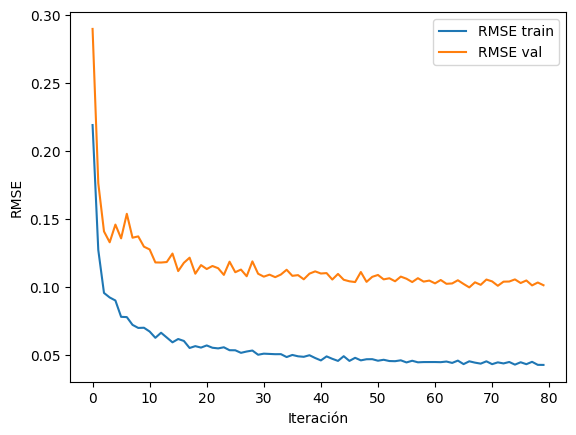

In [11]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend()#;

In [12]:
## Evaluación del modelo en los diferentes conjuntos

# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.039
  RMSE val:	 0.095
  RMSE test:	 0.016


## Quinta parte: comparación de las predicciones del modelo 

In [13]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

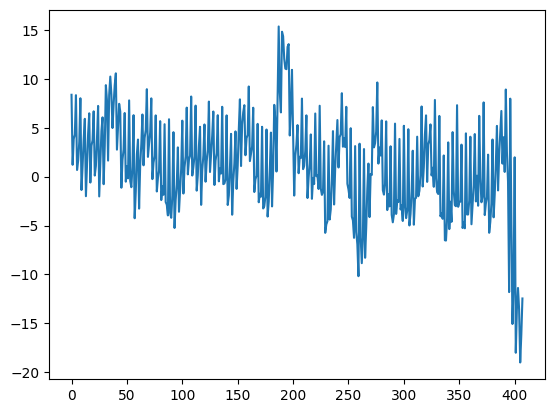

In [14]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores)#;

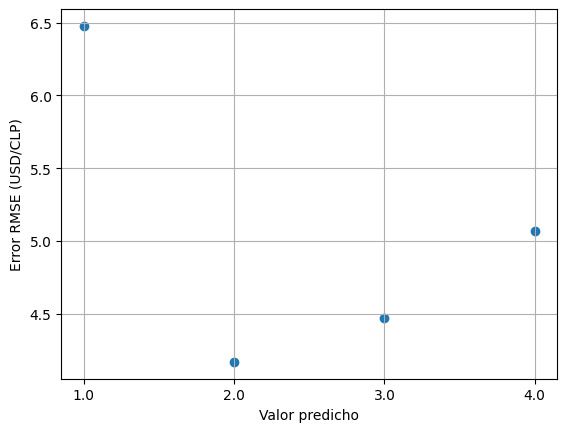

In [15]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # 4995x4
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

# Graficar rmse para cada timestep
t = np.linspace(1,4,4)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Step predicho')
ax.set_ylabel('Error RMSE (USD/CLP)')
plt.xticks(ticks=t, labels=t)
plt.grid();

In [28]:
#Predicción de las próximas 4 semanas 
print(x_tr_s.shape) #input 156

xarray = vl.values
x_pred = np.array(x_vl_s[-1,:,:])

x_pred = x_pred.reshape(1,156,3)
#x_pred[:,:,0]=scaler.transform(x_pred[:,:,0])
print(x_pred.shape)

y_pred = modelo.predict(x_pred,verbose=0)
y_pred = scaler.inverse_transform(y_pred)


(1067, 156, 3)
(1, 156, 3)


In [29]:
y_pred = y_pred.reshape(4,1)

In [30]:
import numpy as np
from datetime import datetime, timedelta

# Obtener la fecha actual
today = datetime.now().date()

# Calcular la fecha de 4 semanas a partir de hoy
four_weeks_from_today = today + timedelta(weeks=5)

# Crear un array de NumPy con fechas desde hoy hasta 4 semanas a partir de hoy
dates = np.arange(today, four_weeks_from_today, dtype='datetime64[W]')

# Imprimir el array resultante
print(dates)

dates = dates[-4:].tolist()

resultados = pd.DataFrame({'Semana':dates,'pred':y_pred.tolist()})

# plot de los resultados de predicción

fig, ax = plt.subplots(figsize = (16,5))

x_data = df.index.values[-9:-1]
y_data = df['Dólar observado'].values[-8:]

ax.plot(x_data,y_data,label = 'Dolar real')

x_predic = [d for d in resultados['Semana'].values]
y_predic = [i[0] for i in resultados['pred'].values]


ax.plot(x_predic,y_predic,label = 'Predicción')

plt.legend()


['2023-08-03' '2023-08-10' '2023-08-17' '2023-08-24' '2023-08-31']


numpy.datetime64('2023-08-06T00:00:00.000000000')

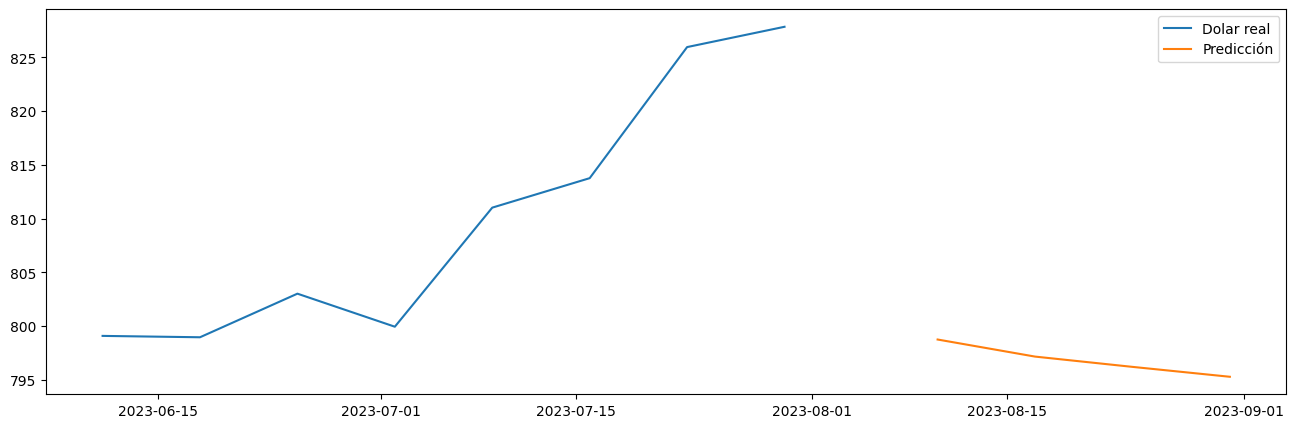